In [1]:
%matplotlib inline 

import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import mpld3

/Users/amit/work/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
matplotlib.style.use('ggplot')

In [4]:
df_initial = quandl.get('WIKI/GOOGL')

In [5]:
df = df_initial.copy()

In [6]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_percent'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100
df['day_percent'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100
df = df[['Adj. Close', 'HL_percent', 'day_percent']]

In [7]:
print df.tail()

            Adj. Close  HL_percent  day_percent
Date                                           
2017-07-17      975.96    1.292748    -0.036873
2017-07-18      986.95    1.935106     1.396195
2017-07-19      992.77    0.870305     0.278785
2017-07-20      992.19    1.427962    -0.482447
2017-07-21      993.84    1.111597     0.489383


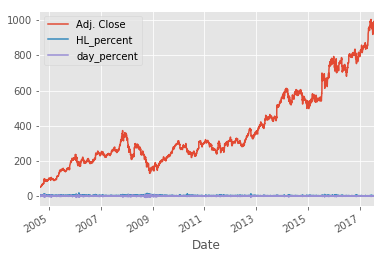

In [8]:
df.plot();

In [9]:
forecast_col = 'Adj. Close'
df.fillna(-9999999, inplace=True)
forecast_days = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_days)
print "Getting predictions for %d days in advance\n"%forecast_days
print df.head()

Getting predictions for 33 days in advance

            Adj. Close  HL_percent  day_percent      label
Date                                                      
2004-08-19   50.322842    8.441017     0.324968  68.752232
2004-08-20   54.322689    8.537313     7.227007  69.639972
2004-08-23   54.869377    4.062357    -1.227880  69.078238
2004-08-24   52.597363    7.753210    -5.726357  67.839414
2004-08-25   53.164113    3.966115     1.183658  68.912727


In [10]:
x = np.array(df.drop(['label'], 1))
x = preprocessing.scale(x)
x_lately = x[-forecast_days:]
x = x[:-forecast_days]

df.dropna(inplace=True)
y = np.array(df['label'])

#Make sure that the length of x and y are equal
print len(x), len(y)

3221 3221


In [11]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2)

In [12]:
clf = LinearRegression()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print "Linear Regression Accuracy is : %.2f%%"%(accuracy*100)

Linear Regression Accuracy is : 97.42%


/Users/amit/work/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [13]:
#Just for comparison. Not used anywhere else
_clf = svm.SVR()
_clf.fit(x_train, y_train)
_accuracy = _clf.score(x_test, y_test)
print "SVM Regression Accuracy is : %.2f%%"%(_accuracy*100)

SVM Regression Accuracy is : 82.50%


In [14]:
#Start actually predicting the values for last forecast_days
forecast_values = clf.predict(x_lately)
print "%s for last %d days is %s with an accuracy of %.2f%%"%(forecast_col, forecast_days, forecast_values, accuracy*100)

Adj. Close for last 33 days is [ 1014.71172057  1020.54726809  1023.14404917   981.46858637   976.26552377
   987.77062433   984.48239129   976.43729058   976.4843177    993.31579801
   986.83403065   996.81212088   995.41908032  1004.12359988   988.21449099
   964.40869518   976.11477312   953.62195013   946.53913568   935.53557407
   948.58937373   944.24005188   957.74729368   968.7230055    971.56396081
   985.38840806   986.3095233    995.65678411   993.86456276  1003.87675672
  1011.53179961  1010.09505733  1012.21660362] with an accuracy of 97.42%


In [15]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
one_day = pd.to_timedelta(24, unit='h')
next_date = last_date + one_day

for day_forecast in forecast_values:
    next_date += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [day_forecast]

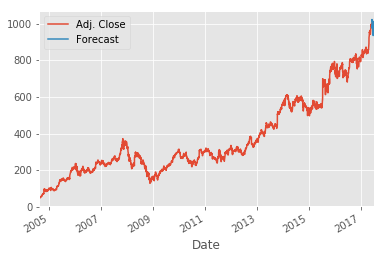

In [18]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=2)